## REINFORCE with Baseline: Monte-Carlo Policy Gradient

Here is the implementation of **REINFORCE-with-Baseline**, a Monte-Carlo policy gradient algorithm. Algorithm is run on following environment from openai.gym:
- CliffWalking-v0

In [0]:
import sys
import numpy as np
import pandas as pd
import gym
from gym import logger as gymlogger
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.style.use('ggplot')
gymlogger.set_level(40) #error only
%matplotlib inline

### CliffWalking environment

- A state in the current position in 12x4 grid
- Action is one of 4 possible directions left,right,up,down

In [2]:
env = gym.make("CliffWalking-v0")
print(env.observation_space)
print(env.action_space)

Discrete(48)
Discrete(4)


### REINFORCE Implementation
- Both policy and value functions are approximated using single layer neural networks (linear approximation)

- A workaround is used to make the episode lengths smaller. Terminate the episode as soon as the agent falls off the cliff

In [0]:
class ValueEstimator(nn.Module):
    """
    Value function approximator. Used single layer neural network
    (same is linear weighting) for approximating the value function.
    """
    def __init__(self, env, lr):
        super(ValueEstimator, self).__init__()
        self.env = env
        self.num_states = env.observation_space.n
        self.model = nn.Sequential(nn.Linear(self.num_states, 1))
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, state):
        state_one_hot = torch.zeros(self.num_states)
        state_one_hot[state] = 1
        return self.model(state_one_hot)
    
    def update(self, current_value, current_return):
        loss_fn = nn.MSELoss()
        loss = loss_fn(current_value, torch.tensor([current_return]))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [0]:
class PolicyEstimator(nn.Module):
    """
    Policy approximator. Used single layer neural network
    (same is linear weighting) for approximating the value function.
    Softmax activation to get the probabilities of different actions.
    """
    def __init__(self, env, lr, min_prob=1e-4):
        super(PolicyEstimator, self).__init__()
        self.env = env
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.min_prob = min_prob
        self.model = nn.Sequential(
            nn.Linear(self.num_states, self.num_actions),
            nn.Softmax(dim=-1)
            )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, state):
        state_one_hot = torch.zeros(self.num_states)
        state_one_hot[state] = 1
        return self.model(state_one_hot)

    def update(self, state, action, advantage):
        state_one_hot = torch.zeros(self.num_states)
        state_one_hot[state] = 1
        action_prob = self.model(state_one_hot).gather(0, torch.tensor(action))
        action_prob = torch.clamp(action_prob, min=self.min_prob)
        loss = - torch.log(action_prob) * advantage
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [0]:
class ReinforceAgent:
    """
    Reinforcement learning agent that learns policy using
    REINFORCE-with-Baseline: MC based policy gradient algorithm
    Args:
        env: gym environment
        policy_lr: learning rate for policy estimator
        value_lr: learning rate for value function estimator
    """
    def __init__(self, env, policy_lr=0.003, value_lr=0.003):
        self.env = env
        self.min_prob = 1e-4
        self.policy_estimator = PolicyEstimator(env, policy_lr, self.min_prob)
        self.value_estimator = ValueEstimator(env, value_lr)

    def sample_episode(self):
        """
        Sample one episode according to approximate policy
        """
        state = self.env.reset()
        episode = []
        num_actions = self.env.action_space.n
        while True:
            action_probs = self.policy_estimator(state).detach().numpy()
            action_probs = (1-self.min_prob)*action_probs + self.min_prob/num_actions
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, info = env.step(action)
            episode.append((state,action,reward))
            if done or reward==-100: break # Terminate episode if agent falls off the cliff
            state = next_state
        return episode    

    def train(self, gamma=1.0, num_episodes=10000):
        """
        Train the agent with REINFORCE-with-Baseline policy gradient

        Args:
            gamma: Discount factor
            num_episodes: Maximum number of episodes to train
        """
        stats = {'episode_lengths': np.zeros(num_episodes),
                'episode_returns': np.zeros(num_episodes)}

        for episode_num in tqdm(range(1, num_episodes + 1), unit='episode', position=0, leave=True):
            episode = self.sample_episode()
            current_return = 0
            T = len(episode)
            for t in reversed(range(T)):
                state, action, reward = episode[t]
                current_return = gamma*current_return + reward
                cur_value = self.value_estimator(state)
                advantage = current_return - cur_value.detach()

                # Update stats
                stats['episode_returns'][episode_num-1] += reward
                stats['episode_lengths'][episode_num-1] += 1

                self.value_estimator.update(cur_value, current_return)
                self.policy_estimator.update(state, action, advantage * gamma**t)
        return stats

In [12]:
agent = ReinforceAgent(env, policy_lr=0.003, value_lr=0.003)
stats = agent.train(gamma=1.0, num_episodes=20000)

100%|██████████| 20000/20000 [04:06<00:00, 81.28episode/s]


### Training Statistics

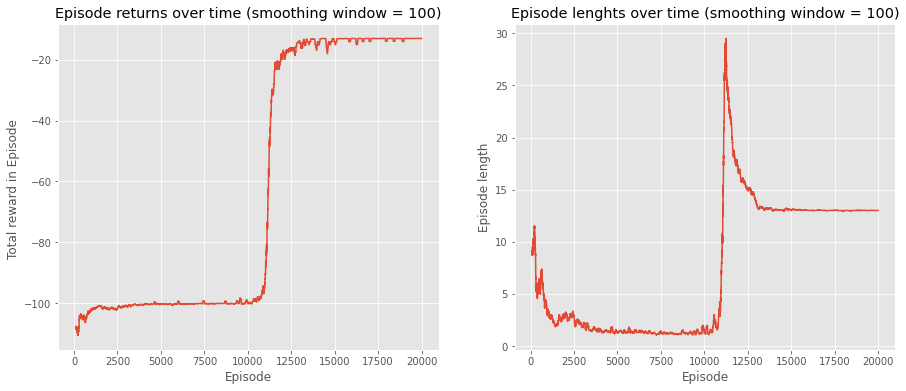

In [13]:
def plot_stats(stats):
    episode_returns = pd.Series(stats['episode_returns']).rolling(100).mean()
    episode_lengths = pd.Series(stats['episode_lengths']).rolling(100).mean()
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(episode_returns)
    ax1.set_title("Episode returns over time (smoothing window = 100)")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Total reward in Episode ")

    ax2.plot(episode_lengths)
    ax2.set_title("Episode lenghts over time (smoothing window = 100)")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Episode length")
    plt.show()

plot_stats(stats)

# Visualizing the learned policy

In [14]:
def display_episode(env, policy_estimator):
    state = env.reset()
    final_score = 0
    for t in range(1000):
        env.render()
        action_probs = policy_estimator(state).detach().numpy()
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        next_state, reward, done, info = env.step(action)
        final_score += reward
        state = next_state
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            print("Final Score: {}".format(int(final_score)))
            break

display_episode(env, agent.policy_estimator)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o